## Implementing agentic workflow and function calling in our local RAG setup using LangGraph.

In [1]:
# importing os module for environment variables
import os

import langchain_core.documents
# import pandas as pd
# importing necessary functions from dotenv library
from dotenv import load_dotenv, dotenv_values

load_dotenv()

True

### Instantiate embedding model (Nomic)

In [2]:
from langchain_nomic.embeddings import NomicEmbeddings

dimensionality : int = 768
embed_model = NomicEmbeddings(model="nomic-embed-text-v1.5", dimensionality=dimensionality) # not quite clear yet what specific dimensionality I have to work with
embed_model.embed_query("My query to look up")[:10]

[-0.014556885,
 0.042907715,
 -0.19152832,
 -0.026611328,
 0.04434204,
 -0.021774292,
 0.04977417,
 0.025512695,
 0.041381836,
 0.0018663406]

### Generate retriever
 Reminder to clean up retriever responses to output info with less boilerplate formatting.

In [3]:
from langchain_pinecone import PineconeVectorStore

index_name : str = "markdown-notes"
vectorstore = PineconeVectorStore(
    index_name=index_name,
    embedding=embed_model,
)
retriever = vectorstore.as_retriever(k=4) # top k = 4
retriever.invoke("object detection")

[Document(page_content='## Object detection', metadata={'Header 1': 'Possibles networks/algorithms', 'Header 2': 'Object detection', 'source': 'data\\computer_science_notes\\JumperCV Project.md'}),
 Document(page_content='# Basics of Object Detection  \nTraining a typical object detection model involves the following steps:  \n1. Creating ground truth data that contains labels of the bounding box and class corresponding to various objects present in the image.  \n2. Coming up with mechanisms that scan through the image to identify regions (region proposals) that are likely to contain objects. In this chapter, we will learn about leveraging region proposals generated by a method named **selective search**', metadata={'Header 1': 'Basics of Object Detection', 'source': 'data\\computer_science_notes\\Basics of Object Detection.md'}),
 Document(page_content='Building a model from scratch should be a consideration only if it gives a considerable boost in accuracy for our specific ouse-case.

### Load our LLM (local LLaMa 3 8b)

In [4]:
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings

model = Ollama(model="llama3:8b",
               keep_alive=1, # keep model loaded to gain time
               temperature=0,
               )

model.invoke("Why is the sky blue ?")

"What a great question!\n\nThe short answer is: scattering of light by tiny molecules in the atmosphere.\n\nHere's a more detailed explanation:\n\nWhen sunlight enters Earth's atmosphere, it encounters tiny molecules of gases like nitrogen (N2) and oxygen (O2). These molecules are much smaller than the wavelength of visible light, so they scatter the light in all directions. This is known as Rayleigh scattering, named after the British physicist Lord Rayleigh, who first described the phenomenon in the late 19th century.\n\nNow, here's the important part: shorter (blue) wavelengths are scattered more than longer (red) wavelengths. This is because the smaller molecules are more effective at scattering the shorter wavelengths. Think of it like a game of pool: the smaller balls (blue light) bounce around more easily than the larger ones (red light).\n\nAs a result, when we look up at the sky, our eyes see the scattered blue light more prominently, making the sky appear blue. The color of t

For all chains, uncomment invoke lines to test out queries.
### Create a Router
This agent will evaluate whether we should use the vectorstore or call a websearch based on a query. At first, the objective was to use this router to *complement* our context when judged necessary, but I will start with this approach first.
We dictate a JSON output to parse, to guarantee and systematize interpretable answers.
Learned info on how to correctly format Llama prompt using special tokens: [https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/](https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/). We start with setting the 'system' role to gie a system message, and end with the assistant header to prompt the model to start generation.

In [5]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

router_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are dedicated to routing a query inputted by a user, either to a vectorstore or a web search.
The vectorstore contains information related to statistical analysis and machine learning concepts and practices.
Queries are routed to the vectorstore when they are questions on the aforementioned subjects. Otherwise, route the
query to web search. You strictly return a binary choice between 'vectorstore' and 'websearch'. Your output should be a JSON
with the only key being 'context_source', nothing else. <|eot_id|>

<|start_header_id|>user<|end_header_id|>
Here is the query you need to route: '{query}' <|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""
router_prompt = PromptTemplate.from_template(router_template)
router = router_prompt | model | JsonOutputParser()

router_toy_query = "object detection technique"
print(router_prompt.format(query=router_toy_query))
# print(router.invoke(input={"query": router_toy_query}))

router_toy_query2 = "why is the sky blue"
print('\n\n', router_prompt.format(query=router_toy_query2))
# print(router.invoke(input={"query": router_toy_query2}))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are dedicated to routing a query inputted by a user, either to a vectorstore or a web search.
The vectorstore contains information related to statistical analysis and machine learning concepts and practices.
Queries are routed to the vectorstore when they are questions on the aforementioned subjects. Otherwise, route the
query to web search. You strictly return a binary choice between 'vectorstore' and 'websearch'. Your output should be a JSON
with the only key being 'context_source', nothing else. <|eot_id|>

<|start_header_id|>user<|end_header_id|>
Here is the query you need to route: 'object detection technique' <|eot_id|>
<|start_header_id|>assistant<|end_header_id|>



 <|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are dedicated to routing a query inputted by a user, either to a vectorstore or a web search.
The vectorstore contains information related to statistical analysis and machine learning conc

### Create our RAG/websearch response chain
 For a first iteration of our prompt, it would answer 'I don't know' when I queried 'vacations in Greece in the summer' but would respond with its latent knowledge when I only typed 'vacations in Greece'. From my observation, it was because the top document retrieved had the word 'sky' in it. I needed to be more explicit in my prompt.

In [6]:
from langchain_core.output_parsers import StrOutputParser

rag_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a virtual assistant strictly designed to provide knowledge based on provided context from a database of documents.
Answer the question based on the context below.
If you have evaluated that the given context cannot help you provide a related answer, reply 'I don't know' and absolutely nothing else.
Don't be too verbose with your answers.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
Query: '{query}'
Context: {context}
Answer:<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""
rag_prompt = PromptTemplate.from_template(rag_template)
rag = rag_prompt | model | StrOutputParser()

rag_toy_query = "object detection technique"
print(rag_prompt.format(query=rag_toy_query, context= retriever.invoke(rag_toy_query)))
# print(rag.invoke(input={"query": rag_toy_query, "context" : retriever.invoke(rag_toy_query)}))

rag_toy_query_2 = "vacations to Greece in the summer"
print('\n\n',rag_prompt.format(query=rag_toy_query_2, context= retriever.invoke(rag_toy_query_2)))
# print(rag.invoke(input={"query": rag_toy_query_2, "context" : retriever.invoke(rag_toy_query_2)}))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a virtual assistant strictly designed to provide knowledge based on provided context from a database of documents.
Answer the question based on the context below.
If you have evaluated that the given context cannot help you provide a related answer, reply 'I don't know' and absolutely nothing else.
Don't be too verbose with your answers.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
Query: 'object detection technique'
Context: [Document(page_content='## Object detection', metadata={'Header 1': 'Possibles networks/algorithms', 'Header 2': 'Object detection', 'source': 'data\\computer_science_notes\\JumperCV Project.md'}), Document(page_content='# Basics of Object Detection  \nTraining a typical object detection model involves the following steps:  \n1. Creating ground truth data that contains labels of the bounding box and class corresponding to various objects present in the image.  \n2. Coming up with mechanisms

### Create an answer grader
We'll establish a chain responsable for evaluating whether a generated response is relevant or not to the original query. For now we won't use this chain to restart a search or redraft.

In [7]:
from langchain_core.output_parsers import StrOutputParser

grader_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a grader responsible for evaluating whether an answer is relevant to a given query.
You strictly return a binary choice between 'yes' and 'no'. Your output should be a JSON
with the only key being 'relevant_answer', nothing else.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
Here is the answer:
\n ------- \n
{answer}
\n ------- \n
Here is the query: '{query}'<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""
grader_prompt = PromptTemplate.from_template(grader_template)
answer_grader = grader_prompt | model | JsonOutputParser()

query_for_grading = "object detection technique"
# answer_to_grade = rag.invoke(input={"query": query_for_grading, "context" : retriever.invoke(query_for_grading)})
print(grader_prompt.format(query=query_for_grading, answer= "answer_to_grade"))
# print(answer_grader.invoke(input={"query": query_for_grading, "answer" : answer_to_grade}))


query_for_grading_2 = "vacations to Greece in the summer"
# answer_to_grade2 = rag.invoke(input={"query": query_for_grading_2, "context" : retriever.invoke(query_for_grading_2)})
print('\n\n',grader_prompt.format(query=query_for_grading_2, answer= "answer_to_grade2"))
# print(answer_grader.invoke(input={"query": query_for_grading_2, "answer" : answer_to_grade2}))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a grader responsible for evaluating whether an answer is relevant to a given query.
You strictly return a binary choice between 'yes' and 'no'. Your output should be a JSON
with the only key being 'relevant_answer', nothing else.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
Here is the answer:

 ------- 

answer_to_grade

 ------- 

Here is the query: 'object detection technique'<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>



 <|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a grader responsible for evaluating whether an answer is relevant to a given query.
You strictly return a binary choice between 'yes' and 'no'. Your output should be a JSON
with the only key being 'relevant_answer', nothing else.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
Here is the answer:

 ------- 

answer_to_grade2

 ------- 

Here is the query: 'vacations to Greece in the summer'<|eot_id|>
<|star

### Implement a web search tool
We'll use TavilySearchResults.

In [23]:
from langchain_community.retrievers import TavilySearchAPIRetriever
web_search_tool = TavilySearchAPIRetriever(k=3)

### Create a graph state
We've made every component of our workflow, we'll represent the relationships between them end exploit them through a graph. Our LangGraph workflow is in three parts: the nodes, the edges, and the graph state.
We set up the graph state first. They represent the variables that are passed around at any point when we go through our nodes.


In [9]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        query: user query
        answer: LLM generation
        documents: retrieved documents from our rag and the internet
        web_search_needed: whether we need a websearch or not
        answer_grade: whether the final answer was judged relevant by our grader, True if yes
        num_steps: number of steps

    """
    query: str
    answer: str
    documents: List[str]
    relevant_answer: bool
    num_steps: int

### Nodes
1. retrieve documents
2. websearch
3. generate an answer
4. grade the answer

In [26]:
from langchain.schema import Document

def retrieve_documents(state: dict) -> dict:
    """
    Retrieve document from vector store.

    :param state: Current state graph
    :return: State graph with documents key added
    """
    print("---RETRIEVING DOCUMENTS FROM VECTOR STORE---")
    query = state["query"]

    documents : list[langchain_core.documents.Document] = retriever.invoke(query)
    return {"query": query, "documents": documents, "num_steps": int(state["num_steps"]) + 1}

In [27]:
def web_search(state: dict) -> dict:
    """
    Search for the web with a query and retrieve top k documents.

    :param state: Current state graph
    :return: State graph with websearch key added
    """
    print("---WEB SEARCH FOR ADDITIONAL INFO---")
    query = state["query"]
    documents = state["documents"]

    web_results : list[langchain_core.documents.Document] = web_search_tool.invoke(query)
    if documents is None:
        documents = web_results
    else:
        documents.extend(web_results)

    return {"query": query, "documents": documents, "num_steps": int(state["num_steps"]) + 1}

In [28]:
def generate_answer(state: dict) -> dict:
    """
    Call LLM to generate answer based on query and context.

    :param state: Current state graph
    :return: State graph with websearch key added
    """
    print("---GENERATING LLM ANSWER BASED ON RETRIEVED CONTEXT---")
    query = state["query"]
    documents = state["documents"]

    answer = rag.invoke(input={"query": query, "context" : documents})

    return {"query": query, "documents": documents, "answer":answer, "num_steps": int(state["num_steps"]) + 1}

In [29]:
def grade_answer(state: dict) -> dict:
    """
    Call LLM to determine if answer is relevant to context or no.

    :param state: Current state graph
    :return: State graph with websearch key added
    """
    print("---GRADING ANSWER BASED ON RELEVANCE TO CONTEXT---")
    query = state["query"]
    documents = state["documents"]
    answer = state["answer"]

    grade : dict = answer_grader.invoke(input={"query": query, "answer" : answer})
    # print(f"Grade JSON: {grade}")
    assert 'relevant_answer' in grade and grade['relevant_answer'] == 'yes' or 'no', 'LLM response should be a relevant_answer JSON key with yes or no as value'
    relevant_answer = grade['relevant_answer'] == 'yes'

    print(f"User query: '{query}'\n")
    print(f"""Final answer:
    \n ------- \n
    {answer}
    \n ------- \n
    Was this answer judged relevant ? : {grade['relevant_answer']}
    """)
    return {"query": query, "documents": documents, "answer": answer, "relevant_answer": relevant_answer, "num_steps": int(state["num_steps"]) + 1}

In [30]:
def state_printer(state: dict) -> None:
    """ print current state """
    print("---STATE PRINTER---")
    print(f"Query = {state['query']}")
    print(f"Documents = {state['documents']}")
    print(f"Answer = {state['answer']}")
    print(f"Relevant answer = {state['relevant_answer']}")
    print(f"Number of Steps = {state['num_steps']}")
    return

### Conditional Edges
Conditional edges establish points at which decisions have to be made. In our case, when choosing to route between websearch and rag retrieval.

In [31]:
def route_to_research_or_rag(state:dict) -> str:
    print("---ROUTE QUERY---")
    query = state['query']
    print(f"Given query: {query}\n")
    decision = router.invoke(input={"query": query})
    print(f"Decision: {decision}")
    assert 'context_source' in decision and decision['context_source'] == 'vectorstore' or 'websearch', "LLM response should be a context_source " \
                                                                                      "JSON key with vectorstore or websearch as value"
    route = decision['context_source']
    print(f"---ROUTE QUERY TO  {str.upper(route)}---")
    return route

### Build the graph
#### Add nodes to our StateGraph object

In [32]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve_documents", retrieve_documents)
workflow.add_node("web_search", web_search)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("grade_answer", grade_answer)

#### Add edges
Link nodes together.

In [33]:
# set entry point, normally a single node, but because our graph starts with a conditional routing, we use set_conditional_entry_point with our conditional edge
workflow.set_conditional_entry_point(route_to_research_or_rag,
                                     {
                                         "websearch": "web_search",
                                         "vectorstore": "retrieve_documents",
                                     })

workflow.add_edge("retrieve_documents", "generate_answer")
workflow.add_edge("web_search", "generate_answer")
workflow.add_edge("generate_answer", "grade_answer")
workflow.add_edge("grade_answer", END)

### Compile the workflow

In [34]:
# Compile
app = workflow.compile()

### Test our workflow

In [35]:
QUERIES = [
    "object detection technique",
    "vacations spots to Greece in the summer",
    "Explain cross-entropy",
    "Learning rate",
    "When was Leonardo De Vinci born ?",
]

In [36]:
from pprint import pprint
# run the agent
inputs = {"query": QUERIES[1], "num_steps":0}
for outputs in app.stream(inputs):
    for key, value in outputs.items():
        pprint(f'Finished running: {key}:')

---ROUTE QUERY---
Given query: vacations spots to Greece in the summer

Decision: {'context_source': 'websearch'}
---ROUTE QUERY TO  WEBSEARCH---
---WEB SEARCH FOR ADDITIONAL INFO---
'Finished running: web_search:'
---GENERATING LLM ANSWER BASED ON RETRIEVED CONTEXT---
'Finished running: generate_answer:'
---GRADING ANSWER BASED ON RELEVANCE TO CONTEXT---
User query: 'vacations spots to Greece in the summer'

Final answer:
    
 ------- 

    Some popular vacation spots in Greece for the summer include Fourkouvouni, Areti, Schinopi, Fyropotamos, Mandrakia, and Aghios Konstantinos. Klima is also a great spot to take in the sunset.
    
 ------- 

    Was this answer judged relevant ? : yes
    
'Finished running: grade_answer:'


We can visualize our state graph.

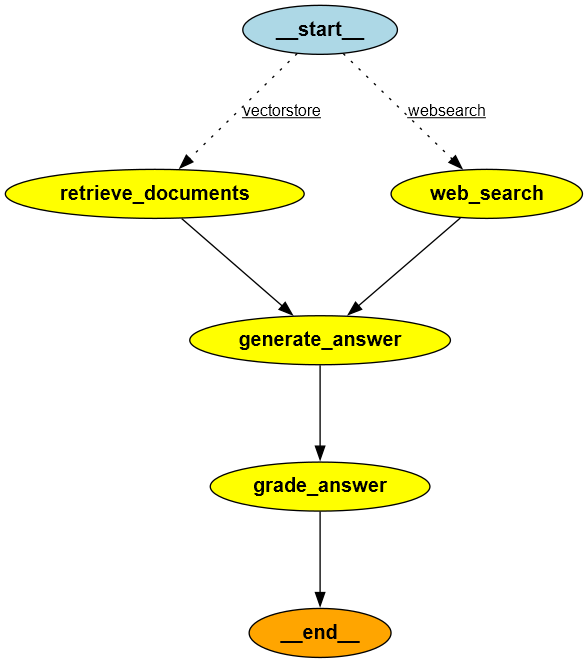

In [39]:
from IPython.display import Image

Image(app.get_graph().draw_png())

We have successfully leveraged LangGraph to create an agentic workflow for our LLM, that not only takes advantage of the index embeddings of our local documents, but also information from the internet through function calling. We check if the user's query is in relation to the subject of our documents, and complement the context with web results if not. Next time we'll come up with a more sophisticated workflow by using the `grade_answer` node to regenerate a new answer with a web search (if not done yet). Either we'll do that or try to implement a specific agent architecture for our needs. I want to monitor all of this through LangSmith, and finally want to test our RAG on an actual frontend through LangServe Chat Playground (this also necessitates conversational memory). The next version of this implementation will be a module.